** DATA **

- PassengerId

- Pclass: 1st, 2nd or 3rd class

- Sex

- Age

- SibSp: # of siblings / spouses

- Parch: # of parents / children

- Fare: ticket price.

- Cabin: cabin number.

- Embarked: port of embarcation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [271]:
import pprint
import pandas as pd

data = pd.read_csv('train.csv')

#data = data.rename(columns = {'PassengerId' : 'Id'})

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [272]:
data['Survived'].groupby(data['Pclass']).describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,0.629630,0.484026,0.0,0.0,1.0,1.0,1.0
2,184.0,0.472826,0.500623,0.0,0.0,0.0,1.0,1.0
3,491.0,0.242363,0.428949,0.0,0.0,0.0,0.0,1.0


In [273]:
data['Survived'].groupby(data['Sex']).describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,314.0,0.742038,0.438211,0.0,0.0,1.0,1.0,1.0
male,577.0,0.188908,0.391775,0.0,0.0,0.0,0.0,1.0


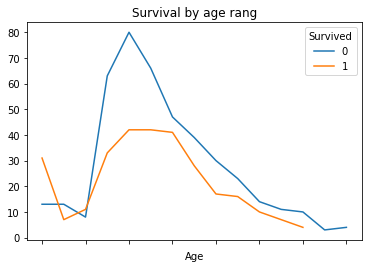

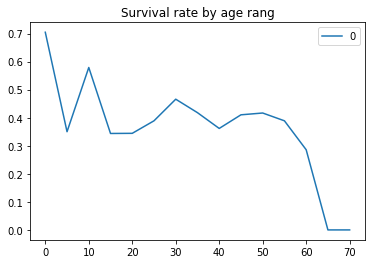

In [274]:
import itertools

age_bins = [x for x in range(0,80,5)]
cutted = pd.cut(data.Age, age_bins)
byage = data.groupby(['Survived', cutted]).size()
byage.unstack().T.plot(title='Survival by age rang')

survival_percentage = pd.DataFrame([x[1] / sum(x) for x in itertools.zip_longest(byage[0], byage[1], fillvalue=0)], age_bins[:-1])
survival_percentage.plot(title='Survival rate by age rang')

In [275]:
def clean_data(data):
    X = data.copy()
    del X['Name']
    del X['Ticket']
    del X['Cabin']
    del X['Embarked']
    del X['PassengerId']
    del X['Fare']

    # we encode the sex labels with "One hot encoding"
    X['IsFemale'] = pd.get_dummies(X, columns=['Sex'])['Sex_female']
    X.drop('Sex', axis=1, inplace=True)
    
    return X

In [281]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

X = clean_data(data)

# we clean the data with empty age (it will not help to train a good model)
X = X.dropna(axis=0, subset=['Age'])

y = X['Survived']
del X['Survived']

best_score = { 'F1': 0, 'Accuracy': 0 }
best_cls = None
for hu1 in range(3,10):
    for hu2 in range(1,5):
        for i in range(5): #random subsets
            # we separate it to two datasets: training (80), testing (20)
            trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2)

            # defining the model to train
            cls = MLPClassifier(hidden_layer_sizes=(hu1, hu2), activation='logistic', max_iter=1000)

            # we train it with our training set
            cls.fit(trainX, trainY)

            # We evaluate the model over our testset
            predictedY = cls.predict(testX)
            score = f1_score(testY, predictedY)
            if(score > best_score['F1']):
                best_cls = cls
                best_score = { 'F1': score, 'Accuracy': accuracy_score(testY, predictedY), 
                              'HiddenUnits' : (hu1, hu2) }

print(best_score)

/home/german/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/german/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'F1': 0.8037383177570094, 'Accuracy': 0.8531468531468531, 'HiddenUnits': (9, 1)}


In [278]:
# Once we got our model trained, we can use it to predict the results for the whole test dataset

def create_submission(classifier):
    test_data = pd.read_csv('test.csv')
    X_test = clean_data(test_data)

    # we need to fill the age column in case it is NaN
    # v1 ---- we fill it with the mean value
    X_test['Age'].fillna(value=X_test['Age'].mean(), inplace=True)

    predictions = classifier.predict(X_test)

    submission_dataframe = pd.DataFrame()
    submission_dataframe['PassengerId'] = test_data.PassengerId
    submission_dataframe['Survived'] = predictions

    submission_dataframe.to_csv('submission_210119_v0.csv', index=False)
    
    return submission_dataframe
    
create_submission(best_cls)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
